In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [5]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [6]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [8]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns = returns.rename(columns={"Settle": "returns"})
returns.tail()

,returns
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


### Lagged Returns 

In [27]:
# Create a lagged return using the shift function
returns['Lagged Returns'] = returns.returns.shift()
returns.dropna(inplace=True)
returns.head()

,returns,Lagged Returns
Date,,
1990-01-04,1.756933,0.584197
1990-01-05,-0.827626,1.756933
1990-01-08,0.129496,-0.827626
1990-01-09,-0.632275,0.129496
1990-01-10,-0.404917,-0.632275


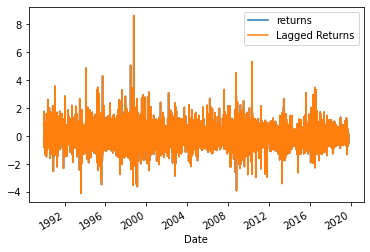

In [28]:
returns.plot()

### Train Test Split

In [29]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = returns[:'2018']
test = returns['2018':]

In [32]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged Returns"].to_frame()
y_train = train["returns"]
X_test = test["Lagged Returns"].to_frame()
y_test = test["returns"]

# Linear Regression Model

In [47]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000029A73CC28B0>,
      dtype=object)

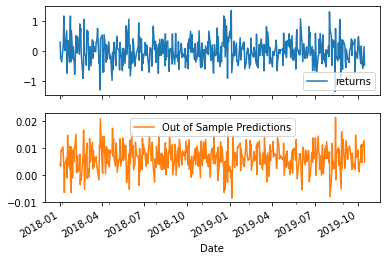

In [48]:
# Make a prediction of "y" values using just the test dataset
testing_results = y_test.to_frame()
testing_results['Out of Sample Predictions'] = model.predict(X_test)
testing_results.plot(subplots=True)

In [49]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
testing_results_20 = testing_results.head(20)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000029A73D72D60>,
      dtype=object)

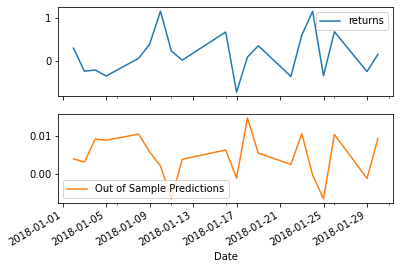

In [50]:
# Plot the first 20 predictions vs the true values
testing_results_20.plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [51]:
testing_results.head()

,returns,Out of Sample Predictions
Date,,
2018-01-02,0.297285,0.003894
2018-01-03,-0.240479,0.003081
2018-01-04,-0.213028,0.009118
2018-01-05,-0.353933,0.008810
2018-01-08,0.062017,0.010392


In [54]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 

mse = mean_squared_error(testing_results['returns'],
                        testing_results['Out of Sample Predictions'])
# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Mean Squared Error(MSE): {mse}")
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Mean Squared Error(MSE): 0.1710966387525008
Out-of-Sample Root Mean Squared Error (RMSE): 0.413638294591423


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000029A73FF0CA0>,
      dtype=object)

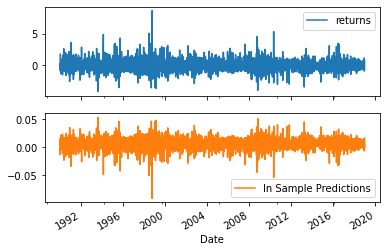

In [55]:
# Construct a dataframe using just the "y" training data:
# Add a column of "in-sample" predictions to that dataframe:  
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_train)

training_results = y_train.to_frame()
training_results["In Sample Predictions"] = predictions
training_results.plot(subplots=True)


In [57]:
# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
mse = mean_squared_error(training_results['returns'],
                        training_results['In Sample Predictions'])
# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"In-Sample Mean Squared Error (MSE): {mse}")
print(f"In-Sample Root Mean Squared Error (RMSE): {rmse}")


In-Sample Mean Squared Error (MSE): 0.48751841703944515
In-Sample Root Mean Squared Error (RMSE): 0.6982251907797692


# Conclusions

Based on the MSE as a measure of prediction error and RMSE as a measure of goodness of fit, out-of-sample performance seems to have less error in predicting returns than in-sample predictions. Based on RMSE the in-sample predictions have a higher goodness of fit.